<a href="https://colab.research.google.com/github/emrehangorgec/GANsNFTs/blob/main/Generative_Art_NFTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment and Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Requirements


## GANs' Repos


In [ ]:
# clone the GAN's repos
!cd /content/drive/MyDrive/GANsNFTs/repos
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git /content/drive/MyDrive/GANsNFTs/repos/pytorch-CycleGAN-and-pix2pix
!git clone https://github.com/tensorlayer/SRGAN.git /content/drive/MyDrive/GANsNFTs/repos/SRGAN

In [ ]:
!pip install -r /content/drive/MyDrive/GANsNFTs/repos/pytorch-CycleGAN-and-pix2pix/requirements.txt

In [ ]:
!pip install --upgrade openai

In [ ]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.2 MB/s eta 0:00:00


## Interface

In [ ]:
!pip install ipywidgets

# API Configurations


In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-proj-nnC3biEGepCwamKhhcvrT3BlbkFJ1PEaIxRxadXO0PbHLXM0'

In [ ]:
print("API Key Set:", os.environ["OPENAI_API_KEY"])

API Key Set: sk-proj-nnC3biEGepCwamKhhcvrT3BlbkFJ1PEaIxRxadXO0PbHLXM0


In [ ]:
!pip show openai

In [ ]:
# Check if 'OPENAI_API_KEY' exists without printing it
is_api_key_set = 'OPENAI_API_KEY' in os.environ
print("Is the API key set?", is_api_key_set)

Is the API key set? True


# Application of GANs

## Text to Image Generation with DALL-E

In [ ]:
import os, openai, requests
from IPython.display import Image, display
from ipywidgets import Button, Dropdown, IntSlider, Layout, Text, interact_manual

In [ ]:
# Function to save prompts to a text file
def save_prompt(
    prompt,
    filename="/content/drive/MyDrive/GANsNFTs/CycleGAN/Generated-Images-DALL-E/prompts.txt",
):
    with open(filename, "a") as file:
        file.write(prompt + "\n")


# Update the size dropdown options based on the selected model version of DALL-E
def update_size_options(*args):
    if model_version.value == "dall-e-2":
        image_size.options = ["512x512", "256x256"]
    elif model_version.value == "dall-e-3":
        image_size.options = ["1024x1024", "1024x1792", "1792x1024"]
    else:
        image_size.options = ["1024x1024"]

In [ ]:
# Definition of dropdown widgets
model_version = Dropdown(options=["dall-e-2", "dall-e-3"], description="Model:")
image_size = Dropdown(description="Size:")
image_quality = Dropdown(options=["standard", "high"], description="Quality:")
num_images = Dropdown(options=[1, 2, 3, 4, 5], description="Number:", value=1)
prompt_input = Text(
    value="", description="Prompt:", layout=Layout(width="800px", height="auto")
)

client = openai.OpenAI()

model_version.observe(update_size_options, "value")

In [ ]:
# Function to handle image generation and saving
def generate_image(model, size, quality, n, prompt):
    save_prompt(prompt)  # Save the prompt when the button is clicked
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )

    directory = "/content/drive/MyDrive/GANsNFTs/CycleGAN/Generated-Images-DALL-E/testA"
    for i, item in enumerate(response.data):
        img_url = item.url
        display(Image(url=img_url))

        image_response = requests.get(img_url)
        file_count = len(
            [
                name
                for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name))
            ]
        )
        filename = f"image_{file_count}.jpg"
        save_path = os.path.join(directory, filename)
        with open(save_path, "wb") as f:
            f.write(image_response.content)

In [ ]:
update_size_options()

In [ ]:
# Create interactive UI
ui = interact_manual(
    generate_image,
    model=model_version,
    size=image_size,
    quality=image_quality,
    n=num_images,
    prompt=prompt_input,
)
ui.widget.children[-2].description = "Generate Image"

interactive(children=(Dropdown(description='Model:', options=('dall-e-2', 'dall-e-3'), value='dall-e-2'), Drop…

## Generate the style content using StyleGAN3

In [ ]:
!python /content/drive/MyDrive/GANsNFTs/repos/stylegan3/gen_images.py

In [ ]:
!python /content/drive/MyDrive/GANsNFTs/repos/stylegan3/gen_images.py --outdir=/content/drive/MyDrive/GANsNFTs/styles/cubism256 --trunc=1 --seeds=120,320,420 \
    --network=/content/drive/MyDrive/GANsNFTs/StyleGAN/gan/experiments/cubism_256x256/00002-stylegan3-t-Cubism-1000-256x256-gpus1-batch32-gamma6.6/network-snapshot-000200.pkl

Loading networks from "/content/drive/MyDrive/GANsNFTs/StyleGAN/gan/experiments/cubism_256x256/00002-stylegan3-t-Cubism-1000-256x256-gpus1-batch32-gamma6.6/network-snapshot-000200.pkl"...
Generating image for seed 120 (0/3) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 320 (1/3) ...
Generating image for seed 420 (2/3) ...


## Neural Style Transfer

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [ ]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [ ]:
content_path = "/content/drive/MyDrive/GANsNFTs/CycleGAN/Generated-Images-DALL-E/testA/image_5.jpg"

In [ ]:
style_path = "/content/drive/MyDrive/GANsNFTs/styles/cubism256/seed0004.png"

In [ ]:
_style_path = "/content/drive/MyDrive/GANsNFTs/styles/cubism256/seed0120.png"

In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [ ]:
content_image = load_image(content_path)
style_image = load_image(style_path)

In [ ]:
_style_image = load_image(_style_path)

In [ ]:
content_image.shape

TensorShape([1, 1024, 1024, 3])

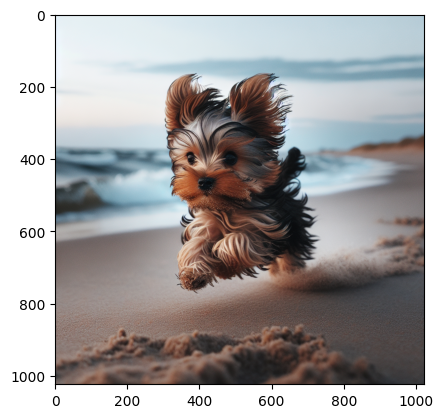

In [ ]:
plt.imshow(np.squeeze(content_image))
plt.show();

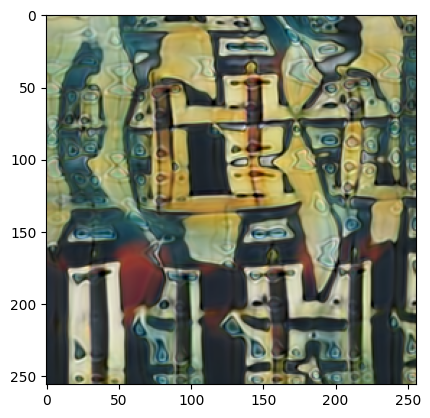

In [ ]:
plt.imshow(np.squeeze(style_image))
plt.show();

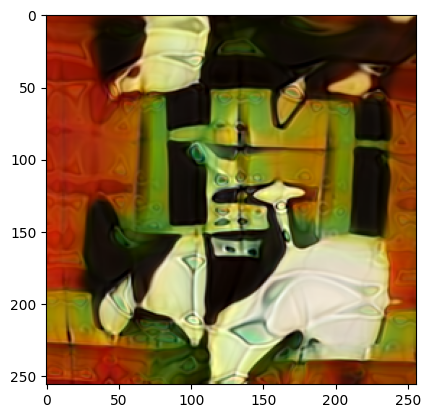

In [ ]:
plt.imshow(np.squeeze(_style_image))
plt.show();

In [ ]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

In [ ]:
stylized_image = model(tf.constant(content_image), tf.constant(_style_image))[0]

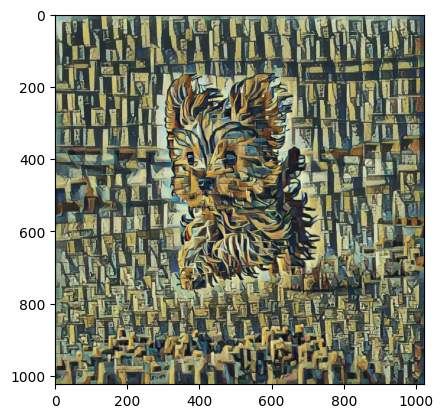

In [ ]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

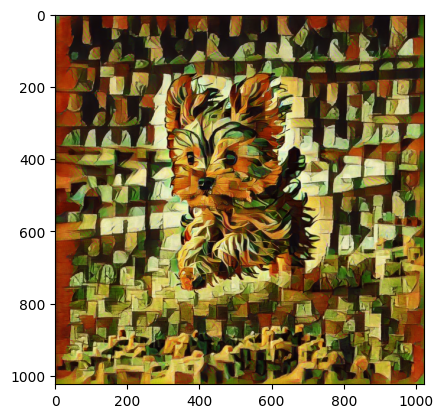

In [ ]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

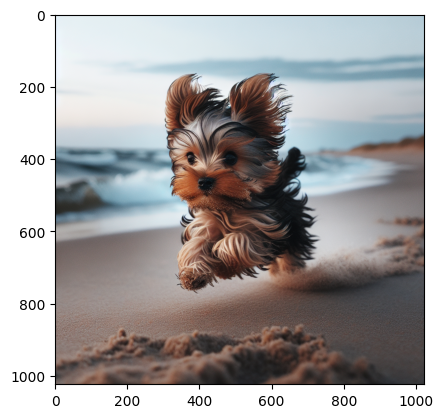

In [ ]:
plt.imshow(np.squeeze(content_image))
plt.show();

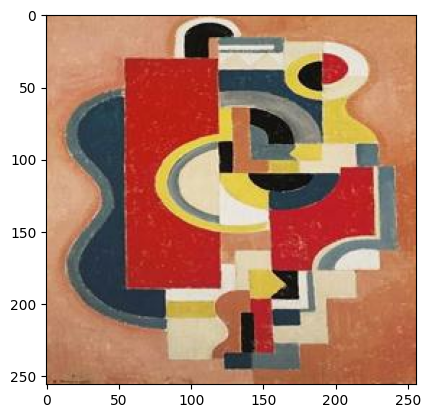

In [ ]:
plt.imshow(np.squeeze(style_image))
plt.show();

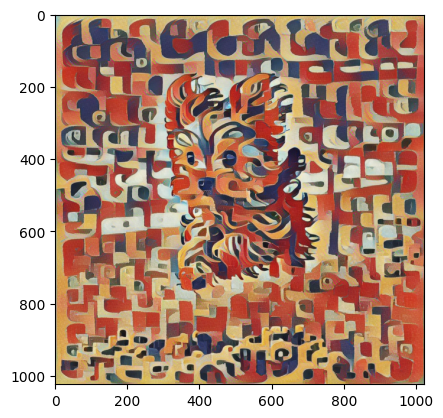

In [ ]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

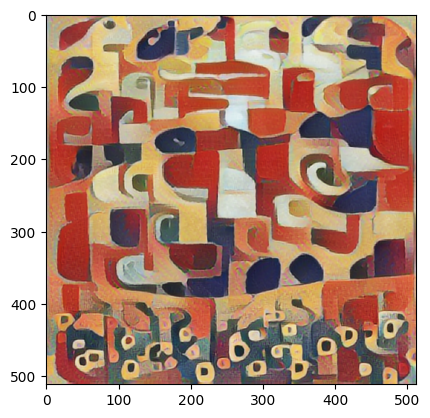

In [ ]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

# Mint NFTs